# Viewing notifications and users

In this notebook we're trying to get a glimpse into users and notifications data over our data sample.

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt

from lib.config import Config
from lib.models.notification import Notification

In [3]:
notifications_filepath = "../data/notifications.csv"

In [4]:
notifications = list()
with open(notifications_filepath, "r") as fp:
    for line in fp.readlines():
        notifications.append(Notification.from_line(line, Config.CSV_HEADERS, ','))
        
span = notifications[-1].timestamp - notifications[0].timestamp
span_seconds = span.total_seconds()

In [5]:
print(f"Number of notifications: {len(notifications)}")
print(f"First notification at: {notifications[0].timestamp}")
print(f"Last notification at: {notifications[-1].timestamp}")
print(f"Sample time span: {span}")

Number of notifications: 337657
First notification at: 2017-08-01 00:06:47
Last notification at: 2017-10-01 01:33:12
Sample time span: 61 days, 1:26:25


In [6]:
# Number of notifications sent to given user over time window
users = dict()
for notification in notifications:
    if notification.user_id not in users:
        users[notification.user_id] = 1
    
    else:
        users[notification.user_id] += 1
    
# Count for distinct notifications count
notifications_count = dict()
for value in users.values():
    if value not in notifications_count:
        notifications_count[value] = 1
        
    else:
        notifications_count[value] += 1

<IPython.core.display.Javascript object>


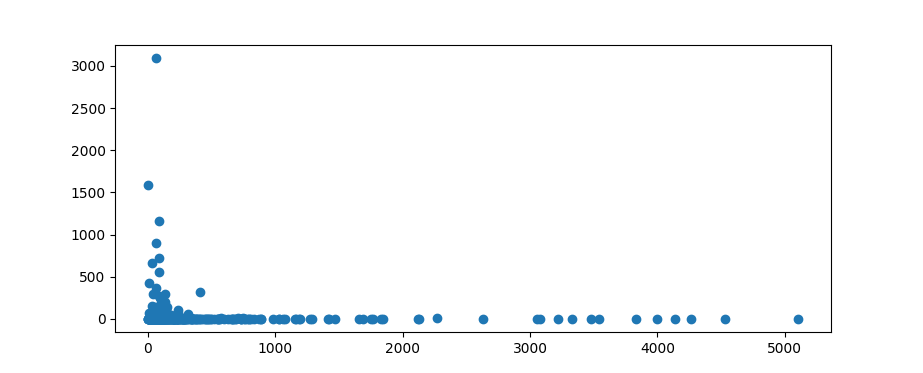

In [27]:
# scattering number of users (Y) receiving a given number of notifications (X)
plt.scatter(sorted(list(notifications_count.keys())), list(notifications_count.values()))
plt.show()

In [38]:
print(f"Total number of users: {len(users)}")
print(f"Average number of notifications per user: {sum(users.values()) / len(users)} over about 61 days")
print(f"Average daily notifications per user: {len(notifications) / span_seconds * 3600 * 24 / len(users)}")

Total number of users: 14094
Average number of notifications per user: 23.95749964523911 over about 61 days
Average daily notifications per user: 0.3923598936134398


## Most users don't receive daily notifications

This is a relevant insight from our sample: on average users receive less than one notification per day and do not suffer of a bombardment problem.

## Taking a look at the more notified users 

We will take a quick look at the more active users defined as receiving on average more than 4 notifications daily.

In [32]:
more_notified_users = {uid: val / (span_seconds / 3600 / 24) 
                       for uid, val in users.items() if val > 4 * (span_seconds / 3600 / 24)}
more_notified_users_daily_avg = sum(more_notified_users.values()) / len(more_notified_users)

In [33]:
print(f"Total number of users notified more than four times daily: {len(more_notified_users)}")
print(f"Average daily number of notifications for those users: {more_notified_users_daily_avg}")

Total number of users notified more than four times daily: 129
Average daily number of notifications for those users: 16.040389304560975


<IPython.core.display.Javascript object>


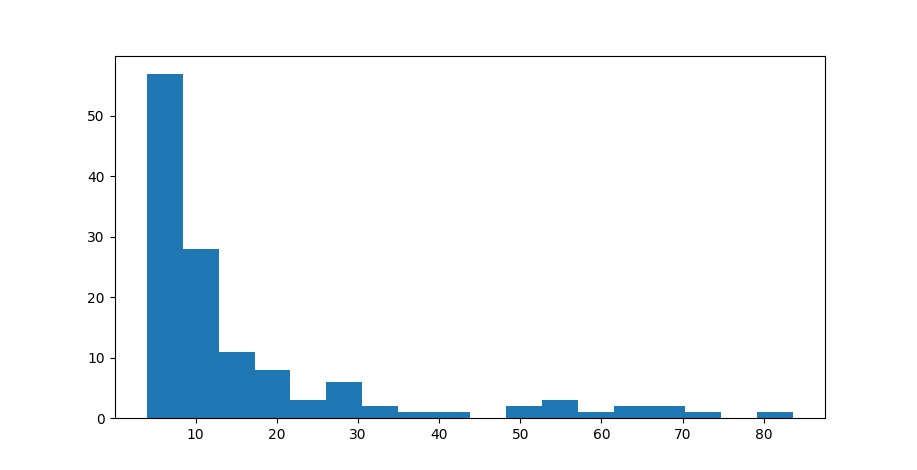

In [36]:
# scattering number of users (Y) receiving a given number of notifications (X)
plt.hist(sorted(list(more_notified_users.values())), bins='auto')
plt.show()

### More notified users are outliers

More notified users range from receiving an average of 5 notifications daily up to > 80.

We will use this insight to focus our bundle computations on those use-cases; we will also use those to compute performance.